# U-net architecture 

Data is one abdominal CT scan with segmentation of the spleen. 
The real big datasets: [spleen segmentation dataset](http://medicaldecathlon.com/)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy.ma as ma
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import nibabel as nib
from collections import OrderedDict
import torch.optim as optim


##  UNet implementation

[Brain MRI Segmentation Challenge](https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation)
[paper](https://arxiv.org/pdf/1505.04597.pdf)
[Reference](https://medium.com/activating-robotic-minds/up-sampling-with-transposed-convolution-9ae4f2df52d0)

<img src="hands-on.img/unet.png" width="200">

In [2]:
class UNet(nn.Module):

    def __init__(self, in_channels=1, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        # controls how far the UNet blocks grow as go down the contracting path
        
        features = init_features

        #set up layers
        self.encoder1 = self.unet_block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = self.unet_block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = self.unet_block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = self.unet_block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = self.unet_block(features * 8, features * 16, name="bottleneck")

        # Transposed convolutions. operations that perform upsampling. reference:
        # https://medium.com/activating-robotic-minds/up-sampling-with-transposed-convolution-9ae4f2df52d0
        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = self.unet_block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = self.unet_block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = self.unet_block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = self.unet_block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )
        
        self.softmax = nn.Softmax(dim = 1)

    # Truns the model on a data vector. 
    # modify the initialization code from 2D/2.5D approaches. If you want to try out the 3D convolutions
    def forward(self, x):
        # Contracting/downsampling path. Each encoder here is a set of 2x convolutional layers
        # with batch normalization, followed by activation function and max pooling
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        # 1-1 layer.
        # a dropout layer is suggested here in original paper. 
        # Will not do here, because he samll dataset leads to overfit
        
        bottleneck = self.bottleneck(self.pool4(enc4))

        # Expanding path
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        out_conv = self.conv(dec1)
        
        return self.softmax(out_conv)

    # Executes "U-net block"
    def unet_block(self, in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

## Training data and labels

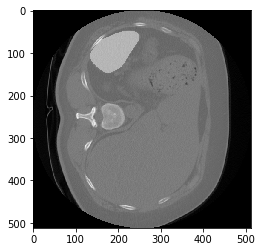

In [9]:
training_volume = nib.load("dataSegmentaion/spleen1_img.nii.gz").get_fdata()
training_label = nib.load("dataSegmentaion/spleen1_label.nii.gz").get_fdata()

plt.imshow(training_volume[:,:,5] + training_label[:,:,5]*500, cmap="gray")

In [10]:
# assume label has one-hot encoding. Distinct classes in label volume:
np.unique(training_label)

array([0., 1.])

Training device

In [11]:
if (torch.cuda.is_available()):
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
device

device(type='cuda')

Instantiate the U-Net class

In [12]:
# use one input channel (one image at a time) and two output channels (background and label)
unet = UNet(1, 2) 

# Move all trainable parameters to the device
unet.to(device)

# use Cross Entropy loss function for this one - OK for per-voxel classification task, 
loss = torch.nn.CrossEntropyLoss()
# can adjust learning rate later
optimizer = optim.Adam(unet.parameters(), lr=0.001)
optimizer.zero_grad()

In [13]:
# trainable parameters 
sum(p.numel() for p in unet.parameters() if p.requires_grad)

7762498

## Training loop

In [14]:
%%time
# Run the model on first 15 slices of the volume (where the spleen segmentation)

# Model for training
unet.train()

for epoch in range(0,10):
    for slice_ix in range(0,15):
        # extract the slice from the volume and convert it to tensor; Normalize the volume to 0..1 range
        slc = training_volume[:,:,slice_ix].astype(np.single)/np.max(training_volume[:,:,slice_ix])
        
        # Model accepts a tensor of size (batch_size, channels, w, h).  
        # Create the missing dimensions. Move data to device
        slc_tensor = torch.from_numpy(slc).unsqueeze(0).unsqueeze(0).to(device)
        
        # extract the slice from label volume into tensor

        lbl = training_label[:,:,slice_ix]
        lbl_tensor = torch.from_numpy(lbl).unsqueeze(0).long().to(device)

        # Zero-out gradients from the previous pass to start computation from scratch for this backprop run
        optimizer.zero_grad()
        
        # forward pass
        pred = unet(slc_tensor)
        
        # loss function and backpropagation pass
        l = loss(pred, lbl_tensor)
        l.backward()
        optimizer.step()
        
    print(f"Epoch: {epoch}, training loss: {l}")
        

Epoch: 0, training loss: 0.45802223682403564
Epoch: 1, training loss: 0.4125957489013672
Epoch: 2, training loss: 0.38626909255981445
Epoch: 3, training loss: 0.3692973256111145
Epoch: 4, training loss: 0.35833775997161865
Epoch: 5, training loss: 0.3492377996444702
Epoch: 6, training loss: 0.34342581033706665
Epoch: 7, training loss: 0.33871397376060486
Epoch: 8, training loss: 0.3334735929965973
Epoch: 9, training loss: 0.3311334252357483
Wall time: 23.8 s


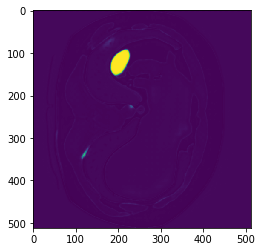

In [15]:
# visualizelast network prediction
plt.imshow(pred.cpu().detach()[0,1])

### Run inference on all slices ofvolume, turn into binary map and save as NIFTI

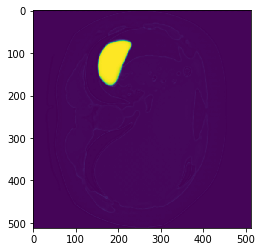

In [17]:
# run inference on one slice first

# Switch model to the eval mode so that no gradient collection happens
unet.eval()

# Pick a slice, convert it into PyTorch tensor,run an inference, convert into 2D NumPy array and visualize 
# CNN return 2 channels - one for each class - target (spleen) and background 

def inference(img):
    tsr_test = torch.from_numpy(img.astype(np.single)/np.max(img)).unsqueeze(0).unsqueeze(0)
    pred = unet(tsr_test.to(device))
    return np.squeeze(pred.cpu().detach())

level = 11

img_test = training_volume[:,:,level]
pred = inference(img_test)

plt.imshow(pred[1])



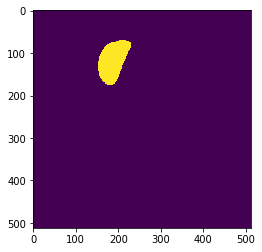

In [18]:
# convert into binary mask using PyTorch's argmax function:
mask = torch.argmax(pred, dim=0)
plt.imshow(mask)

In [21]:
# TCreate a full NIFTI volume. Compute segmentation predictions 
mask3d = np.zeros(training_volume.shape)

for slc_ix in range(training_volume.shape[2]):
    pred = inference(training_volume[:,:,slc_ix])
    mask3d[:,:,slc_ix] = torch.argmax(pred, dim=0)


Check [IPP/IOP](http://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_C.7.6.2.html) and "affine", it's ok here.

In [22]:
org_volume = nib.load("dataSegmentaion/spleen1_img.nii.gz")
org_volume.affine

array([[   0.68359399,    0.        ,    0.        , -349.31652832],
       [   0.        ,    0.68359399,    0.        , -349.31652832],
       [   0.        ,    0.        ,    5.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,    1.        ]])

[NIFTI affines](https://nipy.org/nibabel/coordinate_systems.html)

In [23]:
# Save NIFTI image, copying affine from the original image
img_out = nib.Nifti1Image(mask3d, org_volume.affine)
nib.save(img_out, "dataSegmentaion/out.nii.gz")

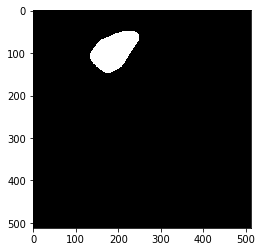

In [7]:
imgout = nib.load("dataSegmentaion/spleen1_label.nii.gz").get_fdata()
plt.imshow(imgout[:,:,5], cmap="gray")

## Concluding remarks
Congrats, you have finished the exercise and trained your very own U-net for biomedical image segmentation!

If you want to dive deeper, here are a few suggestions:

* Try playing with the depth of UNet stacks and see how it affects your quality.
* In the last exercise you have been writing your own convolutions. Try changing the model architecture to one that that works with 2.5D or 3D convolutions.
* Later in this lesson we will talk about Dice and Jaccard similarity measures. Once you get familiar with that content, try changing the loss function and see how it affects the performance. Look up "soft dice" loss function